In [1]:
import yfinance as yf
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import qpsolvers
import cvxopt
from scipy.optimize import minimize

In [2]:
stocks_name = "MU SIRI ECA PFE GE GOOG YPF KGC CR ACB USA CHK AMD F X BAC BABA NOK PCG VALE CSCO FLR ANET BBC PXI LIT PXE SNAP RIG GGB CLF GOLD BMY PBR-A WU KHC XOM TEVA ABBV INTC"
stocks_key = set(stocks_name.split( " " ))

In [3]:
data = yf.download( stocks_name , start="2018-04-04", end="2019-04-04")
data.fillna(method='bfill', inplace=True)

[*********************100%***********************]  40 of 40 downloaded


In [4]:
# Please set parameter of your portofolio
total_value_of_portfolio = 1e6

In [5]:
def return_asset( data , focus_on ):
    return_data = {}
    for key in data[ focus_on ].columns:
        return_data[ key ] = []
        for run in range( 0 , data.shape[0] - 1 ):
            return_data[key].append( data[focus_on][ key ][run + 1 ] / 
                    data[ focus_on ][ key ][ run ] -1 )
    return return_data
                             
class portfolioDataFrame:
    def __init__( self , data , focus_on = "Adj Close"):
        self.data = data
        self.return_data = pd.DataFrame( 
                return_asset( self.data , focus_on ) )
        self.calculate_mean()
        self.calculate_corrcoef()
        self.prepare_data()
        self.pre_process()
    
    def calculate_mean( self ):
        self.mean_dict = {}
        self.variance_dict = {}
        self.std_dict = {}
        for key in self.return_data.columns:
            temp = np.array( self.return_data[ key ].tolist() )
            self.mean_dict[key] = np.mean( temp )
            self.variance_dict[ key ] = np.var( temp )
            self.std_dict[ key ] = np.std( temp )
            
    def calculate_corrcoef( self ):
        temp = []
        for key in self.return_data.columns.tolist():
            temp.append( self.return_data[key].tolist() )
        self.corrcoef = np.corrcoef( np.array( temp ) )
        
    def prepare_data( self ):
        self.key = {};
        self.list_key = []
        self.mean = []
        self.variance = []
        self.std = []
        run = 0
        for key in self.return_data.columns:
            run+=1
            self.list_key.append( key )
            self.key[ key ] = run
            self.mean.append( self.mean_dict[ key ] )
            self.variance.append( self.variance_dict[ key ] )
            self.std.append( self.std_dict[ key ] )
            
    def pre_process( self ):
        one_array = []
        for key in self.key.keys():
            one_array.append( 1 )
        self.matrix_return = np.array( (
                self.mean,
                one_array
                ) )
        self.matrix_std = np.array((
                self.std,
                one_array
                ))
        self.matrix_var = np.array((
                self.variance,
                one_array
                ))
    

In [6]:
port_stock = "AMD CLF CSCO PFE USA"
port_key = set(port_stock.split( " " ))
data = yf.download( port_stock , start="2018-04-04", end="2019-04-04" )
data.fillna(method='bfill', inplace=True)

[*********************100%***********************]  5 of 5 downloaded


In [7]:
port_data = portfolioDataFrame( data )

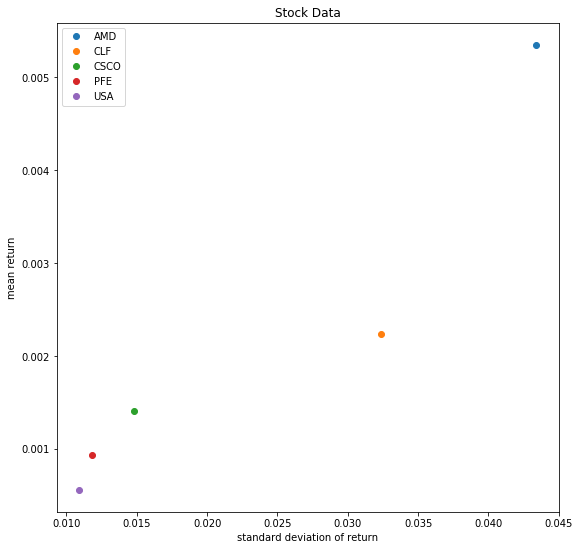

In [8]:
group_data = tuple( port_data.return_data.columns.tolist() )
plt.figure(figsize = ( 9 , 9 ))
for key in group_data:
    plt.plot( port_data.std_dict[key] , port_data.mean_dict[key] , 'o',
            label = key )
#    group_label.append( [key] )
#    x_data.append( port_data.mean[key] )
#    y_data.append( port_data.std[key] )

plt.title('Stock Data')
plt.xlabel( "standard deviation of return")
plt.ylabel( "mean return")
plt.legend()
plt.show()

Above part collect data may be use to calculate perform portfolit optimization.

In [9]:
print( "KEY : " + repr( port_data.key ) )
print( "MEAN: " + repr( port_data.mean ) )
print( "VAR : " + repr( port_data.variance ) )
print( "STD : " + repr( port_data.std ) )

KEY : {'AMD': 1, 'CLF': 2, 'CSCO': 3, 'PFE': 4, 'USA': 5}
MEAN: [0.005351030575262949, 0.002236401221362655, 0.001404677702071751, 0.0009326783466945485, 0.0005610925535937249]
VAR : [0.001881416380403605, 0.0010485951934446115, 0.00021975884372398919, 0.00013904817196685714, 0.0001193345850596695]
STD : [0.0433752968912445, 0.03238201960107818, 0.014824265368779297, 0.011791868892031371, 0.01092403703122932]


In [10]:
mean_return = np.array( port_data.mean , ndmin=2 ).T
mean_return_i = np.linalg.pinv( mean_return )
var_return = np.array( port_data.variance , ndmin=2 ).T
var_return_i = np.linalg.pinv( var_return )
std_return = np.array( port_data.std , ndmin=2 ).T
std_return_i = np.linalg.pinv( std_return )
R = port_data.corrcoef
S = np.diag( port_data.std )
SRS = np.matmul( np.matmul( S , R ) , S ) # covariance matrix
SRS_i = np.linalg.inv(SRS)
one = np.ones( (5 , 1 ) )
one_i = np.linalg.pinv( one )
SRS

array([[1.88141638e-03, 5.08860578e-04, 2.79577045e-04, 1.32937882e-04,
        2.36713812e-04],
       [5.08860578e-04, 1.04859519e-03, 1.68652295e-04, 9.42305759e-05,
        1.18854956e-04],
       [2.79577045e-04, 1.68652295e-04, 2.19758844e-04, 9.15241000e-05,
        9.93758685e-05],
       [1.32937882e-04, 9.42305759e-05, 9.15241000e-05, 1.39048172e-04,
        6.18225668e-05],
       [2.36713812e-04, 1.18854956e-04, 9.93758685e-05, 6.18225668e-05,
        1.19334585e-04]])

# Return Objective
ref01 : https://scaron.info/blog/quadratic-programming-in-python.html
ref02 : https://pypi.org/project/qpsolvers/
ref03 : https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
ref04 : CQF_January_2019_M2L4_Blank_2.pdf use this 
ref05 : https://www.youtube.com/watch?v=cXHvC_FGx24
ref06 : https://towardsdatascience.com/efficient-frontier-optimize-portfolio-with-scipy-57456428323e

In [11]:
A = np.matmul(np.matmul(one.T , SRS_i) , one )[0][0]
B = np.matmul(np.matmul(mean_return.T,SRS_i) , one )[0][0]
C = np.matmul(np.matmul(mean_return.T,SRS_i) , mean_return)[0][0]

In [12]:
print( "A : {:15.10f}\nB : {:15.10f}\nC : {:15.10f}".format( A , B , C ) )

A : 11320.4631861559
B :    4.7420077718
C :    0.0209966275


In [13]:
expect_return = 0.005
lamdha = ( A*expect_return - B ) / ( A * C - B * B )
gamma = (C-B*expect_return) / ( A * C - B * B )
print( "lamdha : {:15.10f}\ngamma  : {:15.10f} ".format( lamdha , gamma ))

lamdha :    0.2409810632
gamma  :   -0.0000126085 


In [14]:
port = np.matmul( SRS_i , (lamdha*mean_return) + gamma*one )

In [15]:
port

array([[ 0.64494935],
       [ 0.14490166],
       [ 0.89463815],
       [ 0.94777989],
       [-1.63226906]])

In [16]:
np.matmul(port_data.matrix_return  , port)

array([[0.005],
       [1.   ]])

In [17]:
np.matmul(port_data.matrix_var , port )

array([[0.00149897],
       [1.        ]])

# Return Object
This part will try to use about scipy optimization method SLSQP

In [18]:
# Part prepare data
global expect_return, expect_variance , L
list_variance = port_data.variance;
list_return = port_data.mean;
i_bound = ( 0.0 , 1.0 )
bound = ( i_bound, i_bound, i_bound, i_bound, i_bound)
init = np.full( 5 , 0.2 )

In [19]:
def objective_variance( weights ):
    summation = 0
    for run in range( len( weights ) ):
        summation += list_variance[ run ] * weights[ run ]
    return summation
def minus_objective_return( weights ):
    summation = 0
    for run in range( len( weights ) ):
        summation -= weights[ run ] * list_return[run]
    return summation
# This is constrain_return will return about delete expect return  
def constrain_return( weights ):
    global expect_return
    summation = expect_return
    for run in range( len( weights ) ):
        summation -= list_return[ run ] * weights[ run ]
    return summation
# This is constrain_mean will return about expect weights
def constrain_weights( weights ):
    summation = 1
    for run in range( len( weights ) ):
        summation -= weights[ run ]
    return summation
# This is constrain_variance will return about expect variance
def constrain_variance( weights ):
    global expect_variance
    summation = expect_variance
    for run in range( len( weights ) ):
        summation -= list_variance[ run ] * weights[ run ]
    return summation

In [20]:
def return_objective( expect ):
    global expect_return
    expect_return = expect
    con1 = {'type' : 'eq' , 'fun' : constrain_return  }
    con2 = {'type' : 'eq' , 'fun' : constrain_weights }
    cons = ( con1 , con2 )
    return minimize( objective_variance , init , method='SLSQP' , constraints=cons , bounds=bound )

In [21]:
result = return_objective( 0.003 )

In [22]:
print( "Detail your situation and condition")
print( "inidividual bound weights : " + repr( i_bound ) )
print( "Your expect retrun : " + str( expect_return ) )
print( "Result : ")
if( not result ):
    print( "\tFailure you can't manage your port in this case")
else:
    print( "\tYour risk : " + str( result.fun ) )
    print( "\tYour weights :")
    for run in range( len( result.x ) ):
        print( "\t\t" + port_data.list_key[ run ] + "\t: " + str( result.x[ run ] ) )

Detail your situation and condition
inidividual bound weights : (0.0, 1.0)
Your expect retrun : 0.003
Result : 
	Your risk : 0.001033437655709943
	Your weights :
		AMD	: 0.3985307236338065
		CLF	: 0.20817905643738926
		CSCO	: 0.15795442296008708
		PFE	: 0.1290625189290937
		USA	: 0.10627327803962382


## Plot efficient frontier

In [23]:
min_value = np.amin( list_return )
max_value = np.amax( list_return )
diff_value = ( max_value - min_value ) / 100.

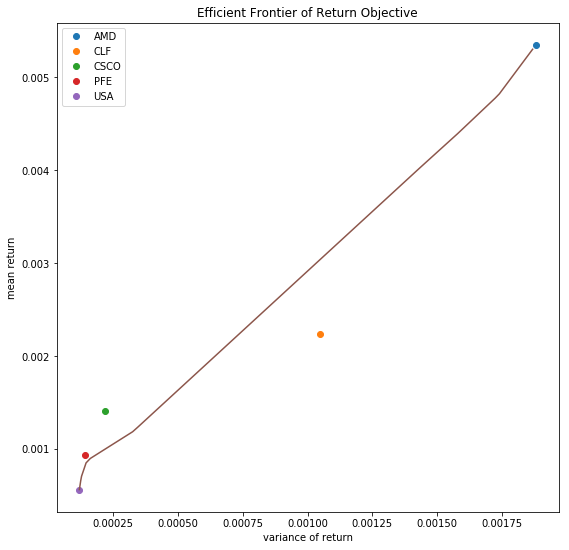

In [24]:
expect_return_return = np.array( [] )
expect_return_risk = np.array( [] )
for target_return in np.arange( min_value , max_value , diff_value ):
    temp_result = return_objective( target_return )
    expect_return_return = np.append( 
            expect_return_return,
            target_return )
    expect_return_risk = np.append(
            expect_return_risk,
            temp_result.fun )
    
plt.figure(figsize = ( 9 , 9 ))
for key in group_data:
    plt.plot( port_data.variance_dict[key] , port_data.mean_dict[key] , 'o',
            label = key )
plt.plot( expect_return_risk , expect_return_return )
plt.title('Efficient Frontier of Return Objective')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.legend()
plt.show()   

# Risk Constraint
max( f(x) ) = - min( -f(x) )

In [25]:
def risk_constraint( expect ):
    global expect_variance
    expect_variance = expect
    con1 = {'type' : 'eq' , 'fun' : constrain_variance }
    con2 = {'type' : 'eq' , 'fun' : constrain_weights }
    cons = ( con1 , con2 )
    return minimize( minus_objective_return , init , method='SLSQP' , constraints=cons , bounds=bound )

In [26]:
result = risk_constraint( 0.0007 )

In [27]:
print( "Detail your situation and condition")
print( "inidividual bound weights : " + repr( i_bound ) )
print( "Your expect variance : " + str( expect_variance ) )
print( "Result : ")
if( not result ):
    print( "\tFailure you can't manage your port in this case")
else:
    print( "\tYour return : " + str( -1.0*result.fun ) )
    print( "\tYour weights :")
    for run in range( len( result.x ) ):
        print( "\t\t" + port_data.list_key[ run ] + "\t: " + str( result.x[ run ] ) )

Detail your situation and condition
inidividual bound weights : (0.0, 1.0)
Your expect variance : 0.0007
Result : 
	Your return : 0.0021422950740062545
	Your weights :
		AMD	: 0.20955732481060718
		CLF	: 0.2020671945423294
		CSCO	: 0.19688090577565598
		PFE	: 0.19598486625508543
		USA	: 0.1955097086163221


## Plot efficient frontier

In [28]:
min_value = np.amin( list_variance )
max_value = np.amax( port_data.variance_dict[ 'AMD'] )
diff_value = ( max_value - min_value ) / 100

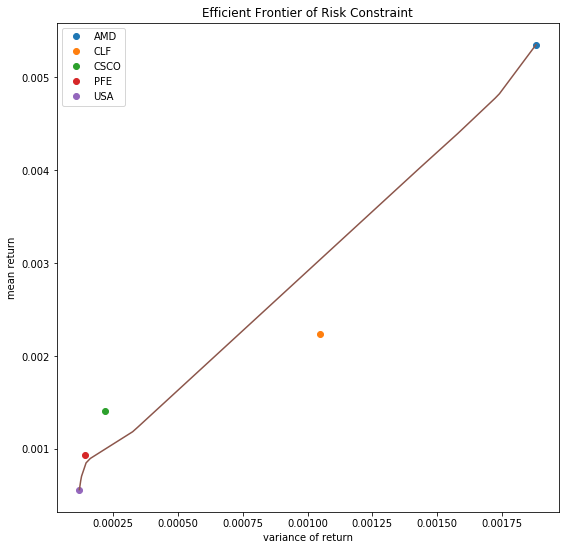

In [29]:
risk_return_return = np.array( [] )
risk_return_risk = np.array( [] )
for target_risk in np.arange( min_value , max_value , diff_value ):
    temp_result = risk_constraint( target_return )
    risk_return_return = np.append( 
            expect_return_return,
            -1.0*temp_result.fun )
    risk_return_risk = np.append(
            expect_return_risk,
            target_risk )
    
plt.figure(figsize = ( 9 , 9 ))
for key in group_data:
    plt.plot( port_data.variance_dict[key] , port_data.mean_dict[key] , 'o',
            label = key )
plt.plot( risk_return_risk , risk_return_return )
plt.title('Efficient Frontier of Risk Constraint')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.legend()
plt.show()   

# Mean-Variance Optimization
max( f(x) ) = -min( -f(x) )

In [30]:
def minus_mean_variance( weights ):
    summation = 0
    global L
    for run in range( len( weights ) ):
        summation -= ( list_return[ run ] - L/2*list_variance[ run ] )*weights[ run ]
    return summation
def report_mean_variance_optimization( result ):
    print( "Report of mean variance optimization")
    for key in result.keys():
        print( "Case" + key + "\t:" )
        print( "\tResult Maximize\t:" + str( result[key].fun ) )
        print( "\tYour weights :")
        for run in range( len( result[key].x ) ):
            print( "\t\t" + port_data.list_key[ run ] + "\t: " + str( result[ key ].x[ run ] ) )

In [31]:
def minus_mean_variance_optimization( L_test ):
    global L
    L = L_test
    con1 = {'type' : 'eq' , 'fun' : constrain_weights }
    cons = ( con1 )
    return minimize( minus_mean_variance , init , method='SLSQP' , constraints=cons , bounds=bound )

In [32]:
test_string = "0.5 1.2 2.3"
test_set = test_string.split(' ')
result_optimization = {}
for test_data in test_set:
    result_optimization[ test_data ] = minus_mean_variance_optimization( float( test_data ) )

In [33]:
report_mean_variance_optimization( result_optimization )

Report of mean variance optimization
Case0.5	:
	Result Maximize	:-0.004880676480162049
	Your weights :
		AMD	: 1.0
		CLF	: 6.245004513516506e-16
		CSCO	: 0.0
		PFE	: 0.0
		USA	: 2.6020852139652106e-17
Case1.2	:
	Result Maximize	:-0.004222180747020785
	Your weights :
		AMD	: 0.9999999999999999
		CLF	: 2.7755575615628914e-17
		CSCO	: 0.0
		PFE	: 1.0408340855860843e-17
		USA	: 1.5612511283791264e-16
Case2.3	:
	Result Maximize	:-0.003187401737798799
	Your weights :
		AMD	: 0.9999999999999982
		CLF	: 6.401129626354418e-16
		CSCO	: 4.3368086899420177e-16
		PFE	: 2.1510571102112408e-16
		USA	: 4.2435673031082644e-16


In [34]:
min_value = -1
max_value = 1
diff_value = 0.01

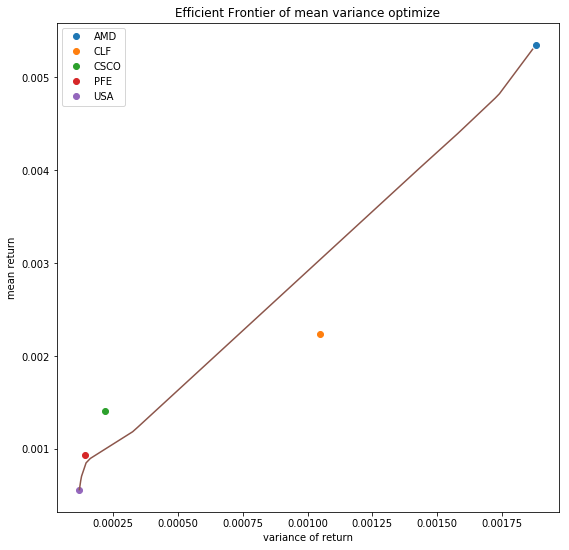

In [35]:
optimize_return = np.array( [] )
optimize_risk = np.array( [] )
for target in np.arange( min_value , max_value , diff_value ):
    temp_result = return_objective( target )
    optimize_return = np.append( 
            optimize_return,
            np.matmul( port_data.matrix_return , result.x )[0] )
    optimize_risk = np.append(
            optimize_risk,
            np.matmul( port_data.matrix_var , result.x )[0] )
    
plt.figure(figsize = ( 9 , 9 ))
for key in group_data:
    plt.plot( port_data.variance_dict[key] , port_data.mean_dict[key] , 'o',
            label = key )
plt.plot( expect_return_risk , expect_return_return )
plt.title('Efficient Frontier of mean variance optimize')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.legend()
plt.show()   

# Result & Discussion

คาดว่าผลที่ได้อาจเป็นเหตุเนื่องจากการเลือกใช้ ฟังก์ชั่น optimization เนื่องจากการใช้ quadratic ได้ลองพยายามใช้แล้ว ไม่สามารถใช้ได้สำเร็จ ติดปัญหาจากการประยุกต์ใช้งาน ไม่สามารถใช้ได้

ผลที่ได้พบว่า ในการ optimization ไม่ว่าจะเลือกทางใด ก็จะได้ผลที่ค่อนข้างใกล้เคียงกัน หมายความการ optimization จะมีจุดๆหนึ่งที่คู่กันเสมอ ไม่ว่าจะเกิดจากการ constrain ในส่วนของ return หรือ risk พบอีกว่า ถ้าคุณกำหนดรูปแบบของการลงทุน short อย่างเดียว หรือ long อย่างเดียว หรือทั้งคู่ จะทำให้ได้กราฟที่มีลักษณะแตกต่างกันออกไป

ในกรณีที่หุ่นที่เราเลือกใช้จัด portfolit มีอัตราส่วนระหว่างความแตกต่างระหว่างผลตอบแทนกับความเสีย่งที่แตกต่างกันมาก มีสิทธิทำให้ weight ที่ใช้มีการ bias ไปฝั่งนั้น เผื่อถ่วงให้คุณมีความเสี่ยงน้อย แสดงว่า หุ้นที่จะเอามาใช้ weight ก็มีผลเช่นกัน 